In [1]:
import re # Regular expressions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # Shows a smart progress meter - wrap iterable with tqdm(iterable)!
import collections 
from collections import Counter, defaultdict

import nltk
from nltk import bigrams, trigrams, ngrams
from nltk.tokenize import word_tokenize 
# requirement: nltk.download("punkt")
import gensim
from gensim.summarization.textcleaner import split_sentences
from gensim.utils import tokenize
from gensim.utils import simple_preprocess 
import itertools
from itertools import chain

import codecs
from IPython.core.display import HTML
plt.style.reload_library()


In [2]:
# Later should be improved: Load all data from a Folder and combine it into one data-frame
df_raw = pd.read_csv('2020_06_23_CE-BVerwG_DE_Datensatz.csv') 
df_raw

,Unnamed: 0,doc_id,text,Gericht,Datum,Entscheidungsart,Senat,Verfahrensart,Ordinalzahl,Eingangsjahr,Suffix
0,1,BVerwG_1997-02-26_U_6_C_3_96_NA.txt,BUNDESVERWALTUNGSGERICHT\nIM NAMEN DES VOLKES\...,BVerwG,1997-02-26,U,6,C,3,96,NaN
1,2,BVerwG_2000-12-14_B_21_WB_107_00_NA.txt,BUNDESVERWALTUNGSGERICHT\nBeschluss\nBVerwG 1 ...,BVerwG,2000-12-14,B,21,WB,107,0,NaN
2,3,BVerwG_2002-01-10_B_9_A_9_02_NA.txt,BUNDESVERWALTUNGSGERICHT\nBESCHLUSS\nBVerwG 9 ...,BVerwG,2002-01-10,B,9,A,9,2,NaN
3,4,BVerwG_2002-01-14_B_4_BN_1_02_NA.txt,BUNDESVERWALTUNGSGERICHT\nBESCHLUSS\nBVerwG 4 ...,BVerwG,2002-01-14,B,4,BN,1,2,NaN
4,5,BVerwG_2002-01-17_B_1_B_12_02_NA.txt,BUNDESVERWALTUNGSGERICHT\nBESCHLUSS\nBVerwG 1 ...,BVerwG,2002-01-17,B,1,B,12,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...
24219,24220,BVerwG_2020-05-07_B_2_B_35_19_NA.txt,BESCHLUSS\nBVerwG 2 B 35.19\nOVG 4 B 33.14\n\n...,BVerwG,2020-05-07,B,2,B,35,19,NaN
24220,24221,BVerwG_2020-05-12_B_4_BN_3_20_NA.txt,BESCHLUSS\nBVerwG 4 BN 3.20\nOVG 2 C 285/18\n\...,BVerwG,2020-05-12,B,4,BN,3,20,NaN
24221,24222,BVerwG_2020-05-13_B_6_PKH_6_19_NA.txt,BESCHLUSS\nBVerwG 6 PKH 6.19\n\nIn der Verwalt...,BVerwG,2020-05-13,B,6,PKH,6,19,NaN
24222,24223,BVerwG_2020-05-18_B_1_B_21_20_NA.txt,"BESCHLUSS\nBVerwG 1 B 21.20, 1 PKH 12.20\nVGH ...",BVerwG,2020-05-18,B,1,B,21,20,NaN


## Import Data-Set

Import the data which sould be used for training and evaluation.

Split the data-set into 90/10 (or other wanted ratio), shuffle indices and return random distribution of documents.


In [3]:
np.random.seed(42) 
def split_dataset(input_text, perc_use, perc_predict): 
    """ input_text: the Data-Frame which sould be processed
        perc_use: the percentage of data which sould be used for training 
        perc_predit: "                                         " prediction analysis and metrics 
    """
    num_doc = len(df_raw) # number of documents
    indices_lst = list(range(num_doc)) # list of (for now) ordered indices of the documents
    np.random.shuffle(indices_lst) # shuffle the lsit randomly 
    
    # define the data-sets for training and prediciton 
    df_use = df_raw.iloc[indices_lst[:round(perc_use*num_doc)]][["doc_id", "Gericht", "Entscheidungsart", "Verfahrensart", "text"]] # Later use full data-set 
    df_predict = df_raw.iloc[indices_lst[round((1-perc_predict)*num_doc):]][["Gericht", "doc_id", "text"]] # Later use full data-set 
    
    # print length of data_frames for validation
    print(len(df_use), len(df_predict))
    
    # reset row index after shuffling, append column with original index
    df_use = df_use.reset_index()
    df_predict = df_predict.reset_index()
    
    return df_use, df_predict

# Run code to create data-sets
df_raw_use, df_raw_predict = split_dataset(df_raw, 1., 0.00) # Later use full data-set 
#df_raw_use, df_raw_predict = split_dataset(df_raw, 0.9, 0.1) # <- this is the complete data-set

24224 0


In [43]:
# "Entscheidungsart": B, U (Beschluss, Urteil)
# "Verfahrensart": B, A, C, P, PB, WNB, PKH, WB, WD, WDS-VR, VR, BN, KSt, AV, F, 

Entscheidungsart = list(set(df_raw_use["Entscheidungsart"]))
Verfahrensart =  list(set(df_raw_use["Verfahrensart"]))

x_names_y_count = []
x_names_y_count.append(("Beschluss", len(df_raw_use.loc[df_raw_use["Entscheidungsart"] == "B"])))
x_names_y_count.append(("Urteil", len(df_raw_use.loc[df_raw_use["Entscheidungsart"] == "U"])))


for item in Entscheidungsart:
    df_zwisch = df_raw_use.loc[df_raw_use["Entscheidungsart"] == item] 
    for item2 in Verfahrensart:
        x_names_y_count.append(((item,item2), len(df_zwisch.loc[df_zwisch["Verfahrensart"] == item2])))

# df_raw_use.drop(df_raw_use.loc[df_raw_use["Entscheidungsart"] != "B"].index, inplace=True)
# df_raw_use

In [47]:
x_names_y_count.sort(key = lambda x: x[1]) 
x_names_y_count.reverse()


In [67]:
ind_list_Beschluss = df_raw_use[df_raw_use["Entscheidungsart"] == "B"].index
ind_list_Urteil = df_raw_use[df_raw_use["Entscheidungsart"] == "U"].index

ind_list_Beschluss


60

# Plotting

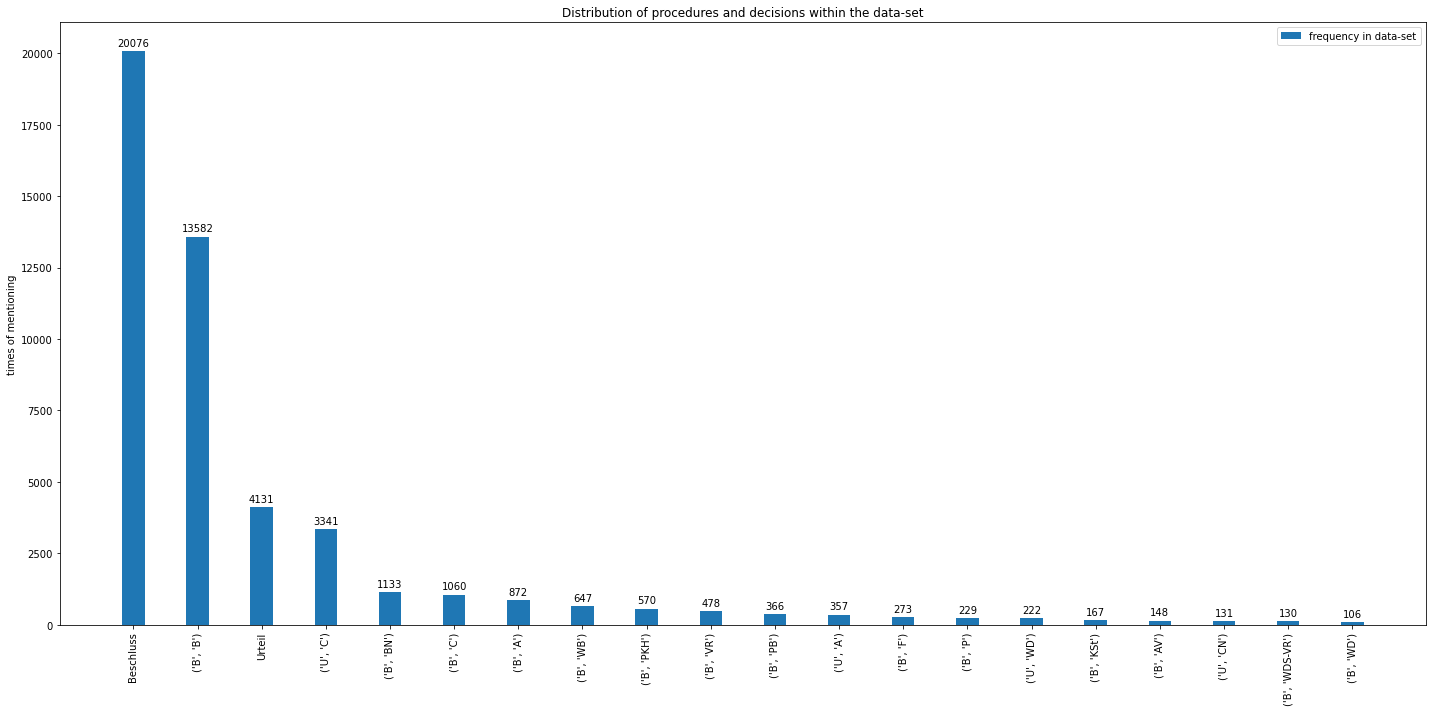

In [51]:

max_length_of_Chart = 20

labels = [item[0] for item in x_names_y_count[:max_length_of_Chart]]
counts = [item[1] for item in x_names_y_count[:max_length_of_Chart]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x, counts, width, label='frequency in data-set')

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xticks(rotation='vertical')
ax.set_ylabel('times of mentioning')
ax.set_title('Distribution of procedures and decisions within the data-set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

fig.tight_layout()
plt.savefig("general_distribution_of_procedure.jpeg")
plt.show()

